# 1. Import the Packages

In [7]:
# Standard Python libraries
import os
import random
import time
from datetime import datetime

# Libraries for data manipulation and visualization
import cv2
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# Libraries for detection and classification
from mtcnn import MTCNN 
from keras_facenet import FaceNet

# 2. Data Set Aquisition

Capturing data set for new user from camera using MTCNN detector

In [8]:
def captureImage():
    # initialize the MTCNN detector
    detector = MTCNN()

    # initialize the video capture object for the default camera
    cam = cv2.VideoCapture(0)

    # initialize catured frame variable

    while True:
        # read the frame from the camera
        ret, frame = cam.read()

        # detect faces using MTCNN
        faces = detector.detect_faces(frame)

        # draw bounding boxes around the faces
        for face in faces:
            x, y, w, h = face['box']
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)

        # show the resulting frame
        cv2.imshow('Real-time Face Detection', frame)

        # press 'q' key to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # release the video capture object and close all windows
    cam.release()
    cv2.destroyAllWindows()

## 3. Preprocessing Image

### 3.1. MTCNN Part

Extract faces from captured image using MTCNN and resize the image into 160x160. After that, do flip and contrast stretching to resized image

In [9]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160, 160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()

    def extract_faces(self, filename):
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        hasil_deteksi = self.detector.detect_faces(img)

        # Getting x, y, w, h from image 'box'
        x, y, w, h = hasil_deteksi[0]['box']
        x, y, w, h = abs(x), abs(y), abs(w), abs(h)

        # Draw rectangle box on detected face
        img = cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 10)

        wajah = img[y:y + h, x:x + w]
        wajah_arr = cv2.resize(wajah, self.target_size)
        return wajah_arr

    def load_faces(self, dir, class_label):
        FACES = []
        Y = []
        for im_name in os.listdir(dir):
            try:
                path = os.path.join(dir, im_name)
                single_face = self.extract_faces(path)
                FACES.append(single_face)
                Y.append(class_label)

            except Exception as e:
                pass
        return FACES, Y

    def parse_filename(self, filename):
        # Mengambil NIM dan Nama dari nama file dengan pola "NIM_Nama_i.jpg"
        nim, nama, _ = filename.split('_')
        return nim, nama

    def load_classes_after_augmentation(self, output_folder=None):
        # Inisialisasi kembali X dan Y
        X = []
        Y = []

        # Membuat subdirektori yang belum ada
        if output_folder:
            for class_label in set(self.Y):  # Menggunakan set(Y) untuk mendapatkan kelas unik
                class_dir = os.path.join(output_folder, class_label)
                if not os.path.exists(class_dir):
                    os.makedirs(class_dir)

        for sub_dir in os.listdir(self.directory):
            path = os.path.join(self.directory, sub_dir)
            FACES, labels = self.load_faces_after_augmentation(path, sub_dir, output_folder=output_folder)
            X.extend(FACES)
            Y.extend(labels)

        return X, Y

    def load_faces_after_augmentation(self, dir, class_label, output_folder=None):
        FACES = []
        Y = []
        for i, im_name in enumerate(os.listdir(dir)):
            try:
                path = os.path.join(dir, im_name)
                single_face = self.extract_faces(path)
                FACES.append(single_face)
                Y.append(class_label)

                nim, nama = self.parse_filename(im_name)

                # Check if the output folder exists for the current class label
                class_output_folder = os.path.join(output_folder, class_label)
                if not os.path.exists(class_output_folder):
                    os.makedirs(class_output_folder)    

                # Jika ingin melakukan augmentasi pada citra di sini, tambahkan proses augmentasi di sini.
                flipped_face = cv2.flip(single_face, 1)  # 1 for horizontal flip
                FACES.append(flipped_face)
                Y.append(class_label)

                contrast_stretched_face = self.contrast_stretching(single_face)
                FACES.append(contrast_stretched_face)
                Y.append(class_label)

                if output_folder:
                    index_start = 1 + i * 3

                    # Simpan citra dengan penamaan yang mengikuti nim dan nama
                    original_filename = f"{nim}_{nama}_{index_start}.jpg"
                    output_path_original = os.path.join(output_folder, class_label, original_filename)
                    cv2.imwrite(output_path_original, cv2.cvtColor(single_face, cv2.COLOR_RGB2BGR))

                    flipped_filename = f"{nim}_{nama}_{index_start + 1}.jpg"
                    output_path_flip = os.path.join(output_folder, class_label, flipped_filename)
                    cv2.imwrite(output_path_flip, cv2.cvtColor(flipped_face, cv2.COLOR_RGB2BGR))

                    stretched_filename = f"{nim}_{nama}_{index_start + 2}.jpg"
                    output_path_stretch = os.path.join(output_folder, class_label, stretched_filename)
                    cv2.imwrite(output_path_stretch, cv2.cvtColor(contrast_stretched_face, cv2.COLOR_RGB2BGR))

            except Exception as e:
                pass
        return FACES, Y

    def contrast_stretching(self, image):
        # Compute minimum and maximum pixel values for each channel
        min_val = np.min(image, axis=(0, 1))
        max_val = np.max(image, axis=(0, 1))

        # Perform contrast stretching for each channel
        stretched = (image - min_val) * (255.0 / (max_val - min_val))
        stretched = np.clip(stretched, 0, 255).astype(np.uint8)

        return stretched

In [10]:
# Gunakan kelas FACELOADING dengan folder direktori "capturedfaces"
face_loader = FACELOADING("capturedfaces")
X, Y = face_loader.load_classes_after_augmentation(output_folder="datawajah")

print(f"Unique Labels After Augmentation: {set(Y)}")
print(f'Total Images in Array After Augmentation: {len(X)} images')



1/1 [==============================] - 0s 33ms/step
Unique Labels After Augmentation: {'rizky-nurhadhi', 'shabrina-katresnawati', 'rizky-mahesa-ramadhan', 'ismail-nurhapid-jamal'}
Total Images in Array After Augmentation: 600 images


Creating dataframe that containing available images from extracted faces and checking total files in the folder

In [11]:
# Initialize main dataset folder
capture_folder = "capturedfaces"

# Initialize main dataset folder
dataset_folder = "datawajah"

In [12]:
def create_dataframe():
    root_folder = dataset_folder

    data = []
  
    # Iterate through the main folder and subfolders
    for root, dirs, files in os.walk(root_folder):
        for file in files:
        # Get the subfolder name (classes)
            classes = os.path.basename(root)

            # Get the full path of the image
            image_path = os.path.join(classes, file)

            # Add data to the list
            data.append({'Classes': classes, 'File Name': file, 'Image Path': image_path})

    # Create a dataframe from the data list
    df = pd.DataFrame(data)

    # Save the dataframe to an Excel file
    excel_file_name = 'dataframe_and_model_files/faces_train_data.xlsx'
    df.to_excel(excel_file_name, index=False)

    print("Dataframe successfully saved to", excel_file_name)

    return df

In [13]:
def total_images_per_class(df):
    # Function to calculate the total number of files in a folder.
    def total_file(classes):
        return len(df[df['Classes'] == classes].values)

    # Iterate through unique classes and print the total number of files for each class
    unique_classes = df['Classes'].unique()
    print("Total number of images in each class :")
    for classes in unique_classes:
        count = total_file(classes)
        print(f"'{classes}': {count} images")

In [14]:
# Create the dataframe
df = create_dataframe()

# Calculate and print the total number of images in each class
total_images_per_class(df)

Dataframe successfully saved to dataframe_and_model_files/faces_train_data.xlsx
Total number of images in each class :
'ismail-nurhapid-jamal': 150 images
'rizky-mahesa-ramadhan': 150 images
'rizky-nurhadhi': 150 images
'shabrina-katresnawati': 150 images


In [15]:
df.sample(5)

,Classes,File Name,Image Path
115,ismail-nurhapid-jamal,1207070060_ISMAIL NURHAPID JAMAL_68.jpg,ismail-nurhapid-jamal\1207070060_ISMAIL NURHAP...
11,ismail-nurhapid-jamal,1207070060_ISMAIL NURHAPID JAMAL_109.jpg,ismail-nurhapid-jamal\1207070060_ISMAIL NURHAP...
171,rizky-mahesa-ramadhan,1207070112_Rizky Mahesa Ramadhan_118.jpg,rizky-mahesa-ramadhan\1207070112_Rizky Mahesa ...
346,rizky-nurhadhi,1207070113_Rizky Nurhadhi_140.jpg,rizky-nurhadhi\1207070113_Rizky Nurhadhi_140.jpg
328,rizky-nurhadhi,1207070113_Rizky Nurhadhi_124.jpg,rizky-nurhadhi\1207070113_Rizky Nurhadhi_124.jpg


### 3.2. FaceNet Part

Embed the dataset to 512 dimension image (1x1x512) and save it into .npz file

In [16]:
embedder = FaceNet()

def get_embedding(face_image):
    face_image = face_image.astype('float32') # 3D(160x160x3)
    face_image = np.expand_dims(face_image, axis=0) # 4D(Nonex160x160x3)
    
    yhat = embedder.embeddings(face_image)

    return yhat[0] #512D image (1x1x152)

In [17]:
EMBEDDED_X = []

for face_image in X:
    EMBEDDED_X.append(get_embedding(face_image))

EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 [==============================] - 0s 88ms/step


In [18]:
embedded_file_name = "dataframe_and_model_files/embedded_dataset.npz"
np.savez_compressed(embedded_file_name, EMBEDDED_X, Y)
print("Embedded dataset successfully saved to", embedded_file_name)

print(f"Unique Labels: {set(Y)}")
print(f'Total Embedded Images in Array: {len(EMBEDDED_X)}')

Embedded dataset successfully saved to dataframe_and_model_files/embedded_dataset.npz
Unique Labels: {'rizky-nurhadhi', 'shabrina-katresnawati', 'rizky-mahesa-ramadhan', 'ismail-nurhapid-jamal'}
Total Embedded Images in Array: 600


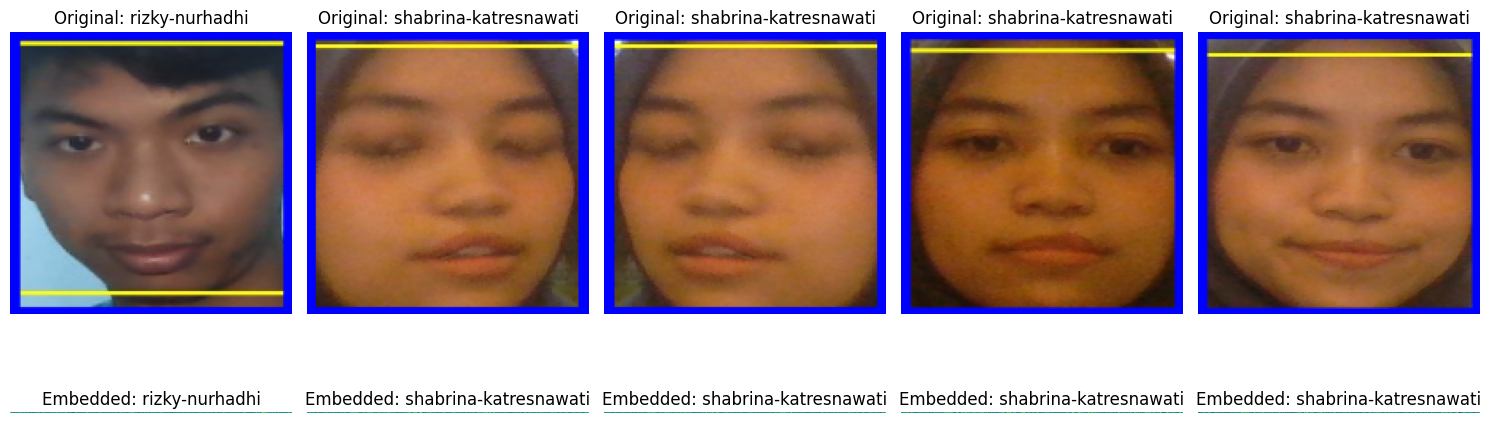

In [19]:
# Choose a few random indices
num_display_samples = 5
sample_indices = random.sample(range(len(EMBEDDED_X)), num_display_samples)

# Display the sample images with their corresponding labels and embeddings
plt.figure(figsize=(15, 6))
for i, index in enumerate(sample_indices):
    plt.subplot(2, num_display_samples, i + 1)
    plt.imshow(X[index])
    plt.title(f"Original: {Y[index]}")
    plt.axis('off')

    plt.subplot(2, num_display_samples, i + num_display_samples + 1)
    plt.imshow(EMBEDDED_X[index].reshape((1, -1)))
    plt.title(f"Embedded: {Y[index]}")
    plt.axis('off')

plt.tight_layout()

In [20]:
# Check correspondence between images in 'X' and labels in 'Y'
for i in range(len(X)):
    print(f"Label: {Y[i]}, File Name: {df['File Name'].iloc[i]}")

Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_1.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_10.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_100.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_101.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_102.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_103.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_104.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_105.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_106.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_107.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_108.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_109.jpg
Label: ismail-nurha

## 4. SVM Classification

### 4.1. K-Fold Cross Validation

In [23]:
import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the embedded dataset
loaded_data = np.load("dataframe_and_model_files/embedded_dataset.npz")
EMBEDDED_X, Y = loaded_data['arr_0'], loaded_data['arr_1']

# Define the parameter grid
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.0001, 0.001, 0.1, 1], 'kernel': ['rbf', 'poly', 'linear']}

# Initialize SVM classifier
svc = svm.SVC(probability=True)

# Initialize StratifiedKFold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=False, random_state=None)

# Initialize GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=stratified_kfold, scoring='accuracy', verbose=1, n_jobs=-1)

# Perform Grid Search Cross Validation
grid_search.fit(EMBEDDED_X, Y)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the entire dataset
y_pred = best_model.predict(EMBEDDED_X)

# Calculate accuracy on the entire dataset
accuracy = accuracy_score(Y, y_pred)
print("Accuracy on Entire Dataset: ", accuracy)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters:  {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
Best Accuracy:  1.0
Accuracy on Entire Dataset:  1.0


In [24]:
def kfold_cross_validation(EMBEDDED_X, Y, num_folds=5):
    # Initialize StratifiedKFold
    stratified_kfold = StratifiedKFold(num_folds, shuffle=False, random_state=None)
    fold_no = 1

    # Lists to store evaluation metrics
    acc_per_fold = []
    classification_reports = []
    confusion_matrices = []
    models = []

    # Perform Stratified K-Fold Cross Validation
    for train_idx, test_idx in stratified_kfold.split(EMBEDDED_X, Y):
        print('========================================================================')
        print(f'Training for fold {fold_no} ...')

        # Split the data into training and testing sets
        X_train, X_test = EMBEDDED_X[train_idx], EMBEDDED_X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        # Fit the SVM model
        svm_model = svm.SVC(probability=True).fit(X_train, y_train)

        # Evaluate the model on the test set
        y_pred = svm_model.predict(X_test)

        # Calculate accuracy
        fold_acc = accuracy_score(y_test, y_pred)
        acc_per_fold.append(fold_acc)

        # Calculate and display confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        print(f'-----\nConfusion Matrix:\n{conf_matrix}')
        confusion_matrices.append(conf_matrix)

        # Calculate and display classification report
        class_report = classification_report(y_test, y_pred)
        print(f'-----\nClassification Report:\n{class_report}')
        classification_reports.append(class_report)

        # Save the model
        models.append(svm_model)

        fold_no += 1

    # Print average scores for all folds
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)}')
    print('--------')

    # Find the best model based on the highest average accuracy
    best_model_idx = np.argmax(acc_per_fold)
    best_model = models[best_model_idx]
    return best_model

# Load the embedded dataset
loaded_data = np.load("dataframe_and_model_files/embedded_dataset.npz")
EMBEDDED_X, Y = loaded_data['arr_0'], loaded_data['arr_1']

# Perform k-fold cross-validation and get the best model
best_model = kfold_cross_validation(EMBEDDED_X, Y, num_folds=5)

Training for fold 1 ...
-----
Confusion Matrix:
[[30  0  0  0]
 [ 0 30  0  0]
 [ 0  0 30  0]
 [ 0  0  0 30]]
-----
Classification Report:
                       precision    recall  f1-score   support

ismail-nurhapid-jamal       1.00      1.00      1.00        30
rizky-mahesa-ramadhan       1.00      1.00      1.00        30
       rizky-nurhadhi       1.00      1.00      1.00        30
shabrina-katresnawati       1.00      1.00      1.00        30

             accuracy                           1.00       120
            macro avg       1.00      1.00      1.00       120
         weighted avg       1.00      1.00      1.00       120

Training for fold 2 ...
-----
Confusion Matrix:
[[30  0  0  0]
 [ 0 30  0  0]
 [ 0  0 30  0]
 [ 0  0  0 30]]
-----
Classification Report:
                       precision    recall  f1-score   support

ismail-nurhapid-jamal       1.00      1.00      1.00        30
rizky-mahesa-ramadhan       1.00      1.00      1.00        30
       rizky-nurhadhi      

### 4.2. Re-Training Model

Test Accuracy: 1.0


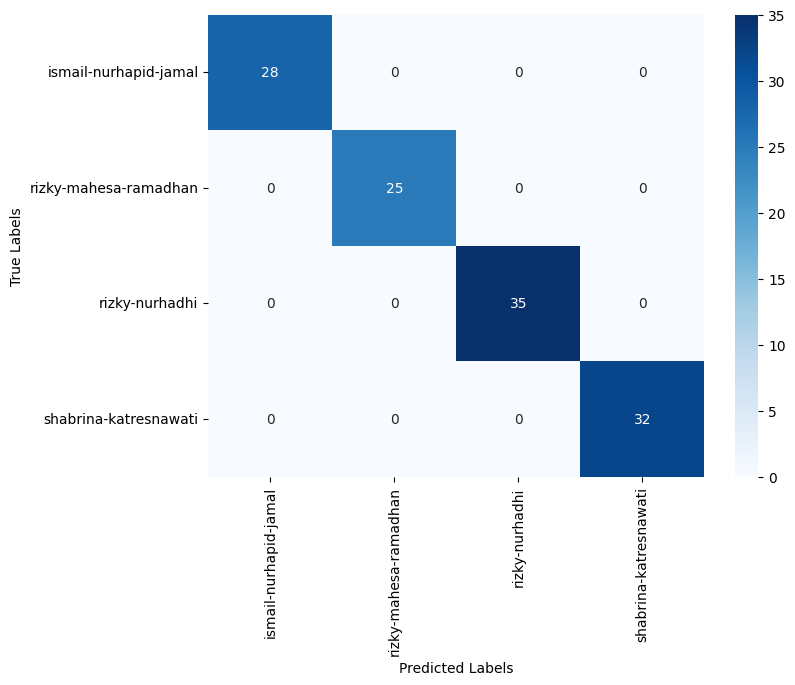

In [30]:
from sklearn.model_selection import train_test_split
import seaborn as sns

def model_retraining(X, Y, test_size=0.2, random_state=None):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    # Fit the SVM model
    svm_model = svm.SVC(probability=True).fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = svm_model.predict(X_test)

    # Calculate accuracy
    svm_test_acc = accuracy_score(y_test, y_pred)
    print(f'Test Accuracy: {svm_test_acc}')

    # Calculate and display confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(Y), yticklabels=np.unique(Y))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return svm_model

# Load the embedded dataset
loaded_data = np.load("dataframe_and_model_files/embedded_dataset.npz")
EMBEDDED_X, Y = loaded_data['arr_0'], loaded_data['arr_1']

# Retrain the model and visualize results
retrained_model = model_retraining(EMBEDDED_X, Y, test_size=0.2, random_state=None)

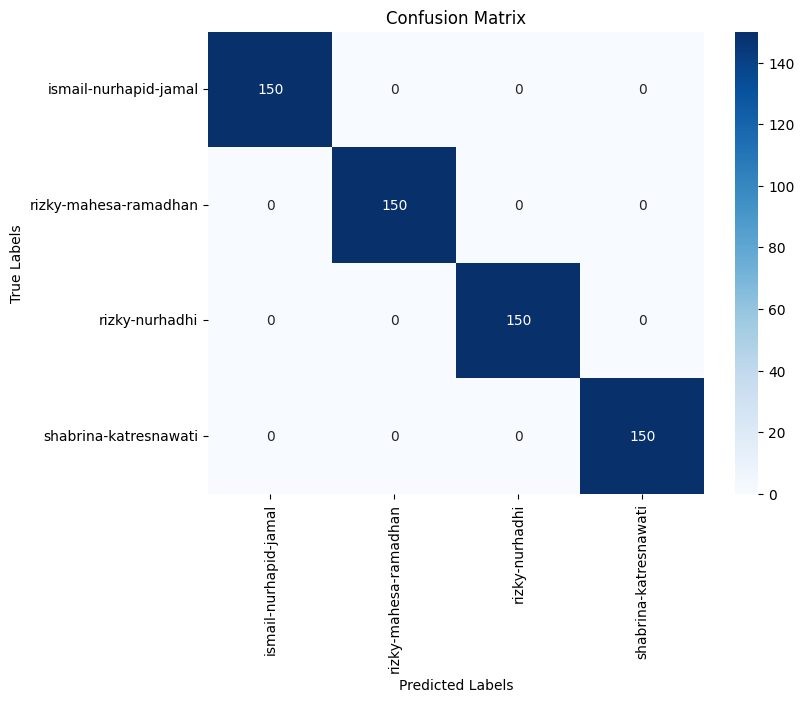

Classification Report:
                       precision    recall  f1-score   support

ismail-nurhapid-jamal       1.00      1.00      1.00       150
rizky-mahesa-ramadhan       1.00      1.00      1.00       150
       rizky-nurhadhi       1.00      1.00      1.00       150
shabrina-katresnawati       1.00      1.00      1.00       150

             accuracy                           1.00       600
            macro avg       1.00      1.00      1.00       600
         weighted avg       1.00      1.00      1.00       600



In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Load the embedded dataset
loaded_data = np.load("dataframe_and_model_files/embedded_dataset.npz")
EMBEDDED_X, Y = loaded_data['arr_0'], loaded_data['arr_1']

# Train the best model on the entire dataset
best_model = svm.SVC(probability=True).fit(EMBEDDED_X, Y)

# Evaluate on the entire dataset
y_pred = best_model.predict(EMBEDDED_X)
accuracy = accuracy_score(Y, y_pred)
conf_matrix = confusion_matrix(Y, y_pred)
class_report = classification_report(Y, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print('Classification Report:')
print(class_report)


# # You can also save the best_model for future use
# import joblib

# joblib.dump(best_model, 'best_model_svm.pkl')
